# Table of Contents
* [Early OCR service experiment](#Early-OCR-service-experiment)
* [Updating annotations with verticle dimension](#Updating-annotations-with-verticle-dimension)
* [Merging boxes](#Merging-boxes)
* [End](#End)


# Early OCR service experiment

This notebook compares the OCR results embedded in the textbook scans to those of eric's api, and MS oxford alone

In [1]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import pprint
import pickle
import json
import requests
import io

In [3]:
import pdfextraction.ocr_pipeline

In [4]:
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image

In [325]:
def query_vision_ocr(image_url, merge_boxes=False, include_merged_components=False, as_json=True):
    api_entry_point = 'http://vision-ocr.dev.allenai.org/v1/ocr'
    header = {'Content-Type': 'application/json'}
    request_data = {
        'url': image_url,
        # 'maximumSizePixels': max_pix_size,
        'mergeBoxes': merge_boxes,
        'includeMergedComponents': include_merged_components
    }

    json_data = json.dumps(request_data)
    response = requests.post(api_entry_point, data=json_data, headers=header)
    print(response.content)
    json_response = json.loads(response.content.decode())
    if as_json:
        response = json_response
    return response

In [5]:
def form_image_url(book_name, page_n, ):
    book_name_no_ext = book_name.replace('.pdf', '_')
    image_base = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/page-images/'
    return image_base + book_name_no_ext + str(page_n) + '.jpeg'

In [333]:
test_file = 'Daily_Science_Grade_2_Evan_Moor_144.jpeg'
test_file = 'Daily_Science_Grade_1_Evan_Moor_104.jpeg'
test_file = 'Daily_Science_Grade_1_Evan_Moor_123.jpeg'
test_file = 'Daily_Science_Grade_2_Evan_Moor_28.jpeg'

In [334]:
# test_page = form_image_url(book_breakdowns['daily_sci'][4], 153)

# pagen = 20
s3_base = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/'
# s3_base = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/cropped-boxes/'
test_page = s3_base + test_file
# test_anno = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/unmerged_annotations/Daily_Science_Grade_6_(Daily_Practice_Books)_Evan_Moor_'+str(pagen) +'.json'
# prev_anno = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/annotations/Daily_Science_Grade_6_(Daily_Practice_Books)_Evan_Moor_'+str(pagen) +'.json'


# ocr_res = json.loads(requests.get(test_anno).content)
# ocr_res_prev = query_vision_ocr(test_page, merge_boxes= True)
ocr_res_prev_unmerged = query_vision_ocr(test_page, merge_boxes= False)

# req = requests.get(test_page)
# tpi = Image.open(io.BytesIO(req.content))

{"detections": [{"value": "E", "score": 1.0, "rectangle": [{"y": 741, "x": 1216}, {"y": 776, "x": 1222}]}, {"value": "leaf stem", "score": 1.0, "rectangle": [{"y": 871, "x": 300}, {"y": 912, "x": 538}]}, {"value": "ally Scien", "score": 1.0, "rectangle": [{"y": 80, "x": 1333}, {"y": 114, "x": 1481}]}, {"value": "Name", "score": 1.0, "rectangle": [{"y": 116, "x": 82}, {"y": 145, "x": 162}]}, {"value": "Big", "score": 1.0, "rectangle": [{"y": 156, "x": 1314}, {"y": 264, "x": 1492}]}, {"value": "Weekly Question", "score": 1.0, "rectangle": [{"y": 168, "x": 285}, {"y": 218, "x": 583}]}, {"value": "Day why do some plants", "score": 1.0, "rectangle": [{"y": 223, "x": 122}, {"y": 300, "x": 910}]}, {"value": "Idea 1", "score": 1.0, "rectangle": [{"y": 256, "x": 1324}, {"y": 300, "x": 1471}]}, {"value": "have flowers?", "score": 1.0, "rectangle": [{"y": 294, "x": 283}, {"y": 344, "x": 704}]}, {"value": "Most plants come from seeds. A seed has a baby", "score": 1.0, "rectangle": [{"y": 434, "x":

In [335]:
for detection in ocr_res_prev_unmerged['detections']:
    print detection['value']

E
leaf stem
ally Scien
Name
Big
Weekly Question
Day why do some plants
Idea 1
have flowers?
Most plants come from seeds. A seed has a baby
WEEK 4
plant inside it. But where do seeds come from? Most
seeds come from flowers Flowers have a special way
of making seeds.
Vocabulary
A. Label the parts of the plant. Use the words in
flower
the part
of
the box. Then color the picture.
a plant that
makes seeds
leaf
stem
flower
roots
B. Where do most seeds come from? Write a complete sentence
to answer the question
Evan-Moor Corp.
EMC 5012. Daily Science
Big Idea 1
Week 4
27


seedless
easy to
dry
ots of sugar
strong skin
seedless easy to dry lots of sugar

In [12]:
for detection in ocr_res_prev_unmerged['detections']:
    print detection['value']

4
Scieo
ily Scie
Name
Big
Weekly Question
Day Why don't all grapes
Idea 2
have seeds?
Farmers grow crops of different grapes for different
WEEK 4
reasons. They grow grapes that are big and juicy for
grape juice. They grow grapes that keep well to make
raisins. Farmers can even grow grapes that are seedless,
Vocabulary
because people like not having to spit out the seeds!
seedless
without seeds
A. Write the traits that each kind of grape might need
to make jelly or raisins. Choose from the box below
seedless
easy to
dry
ots of sugar
strong skin
Grapes for raisins:
Grapes for jelly
B. Pretend you are a farmer growing a new fruit crop. What traits
would you want your fruit to have? Name the fruit and describe
its traits. Then draw a picture of your fruit.
Fruit
Traits I would choose:
600
Big Idea 2
Week 4
Daily Science
EMC 5012.
Evan-Moor Corp.


In [13]:
for detection in ocr_res_prev_unmerged['detections']:
    print detection['value']

4
Scieo
ily Scie
Name
Big
Weekly Question
Day Why don't all grapes
Idea 2
have seeds?
Farmers grow crops of different grapes for different
WEEK 4
reasons. They grow grapes that are big and juicy for
grape juice. They grow grapes that keep well to make
raisins. Farmers can even grow grapes that are seedless,
Vocabulary
because people like not having to spit out the seeds!
seedless
without seeds
A. Write the traits that each kind of grape might need
to make jelly or raisins. Choose from the box below
seedless
easy to
dry
ots of sugar
strong skin
Grapes for raisins:
Grapes for jelly
B. Pretend you are a farmer growing a new fruit crop. What traits
would you want your fruit to have? Name the fruit and describe
its traits. Then draw a picture of your fruit.
Fruit
Traits I would choose:
600
Big Idea 2
Week 4
Daily Science
EMC 5012.
Evan-Moor Corp.


In [357]:
def display_page(raw_page_img, page_layout):
    page_png_stream, y_height = make_png_stream(raw_page_img)
    page_img = make_open_cv_img(page_png_stream)
    for box in page_layout._objs:
        lr, ul = get_bbox_tuple(box, y_height)
        try:
            # print box.get_text()
            pass
        except AttributeError:
            pass
        cv2.rectangle(page_img, ul, lr, color=random_color(), thickness=2)
    display(Image.fromarray(page_img, 'RGB'))


def draw_pdf_with_boxes(book_file, page_range, word_margin=0.1, line_overlap=0.5, char_margin=2.0,
                        line_margin=0.5, boxes_flow=0.5):
    if page_range:
        page_range = map(lambda x: x - 1, page_range)
        suffix = '[{}-{}]'.format(page_range[0], page_range[1])
        raw_multi_pdf = WImage(filename=book_file + suffix)
    else:
        raw_multi_pdf = WImage(filename=book_file)
        
    doc_page_layouts = make_page_layouts(book_file, page_range,
                                         line_overlap,
                                         char_margin,
                                         line_margin,
                                         word_margin,
                                         boxes_flow)
    page_images = raw_multi_pdf.sequence
    for page_n in range(len(page_images)):
        display_page(page_images[page_n], doc_page_layouts[page_n])

def random_color():
    import random
    return random.randint(0,255), random.randint(0,255), random.randint(0,255)

In [626]:
def merge_boxes_service_response(detections, threshold=1.0):
    rectangle_groups = []
    count = 0
    for current_d in detections:
        found_group = False
        for g in rectangle_groups:
            count += 1
            if not found_group:
                for d in g:
                    y_distance = min(abs(d.start_y - current_d.end_y), abs(current_d.start_y - d.end_y))
                    if y_distance < (d.height() * threshold) and current_d.start_x < d.end_x and current_d.end_x > d.start_x:
                        g.append(current_d)
                        found_group = True
                        break
        if not found_group:
            rectangle_groups.append([current_d])

    new_detections = []
    for g in rectangle_groups:
        if len(g) == 1:
            new_detections.append(g[0])
        else:
            min_x = min(map(lambda x: x.start_x, g))
            max_x = max(map(lambda x: x.end_x, g))
            min_y = min(map(lambda x: x.start_y, g))
            max_y = max(map(lambda x: x.end_y, g))
            words = ' '.join(map(lambda x: x.value, g))
            score = ' '.join(map(lambda x: str(x.score), g))
            detection = Detection(min_x, min_y, max_x, max_y, words, score)
            new_detections.append(detection)
    print(count)
    return new_detections

494


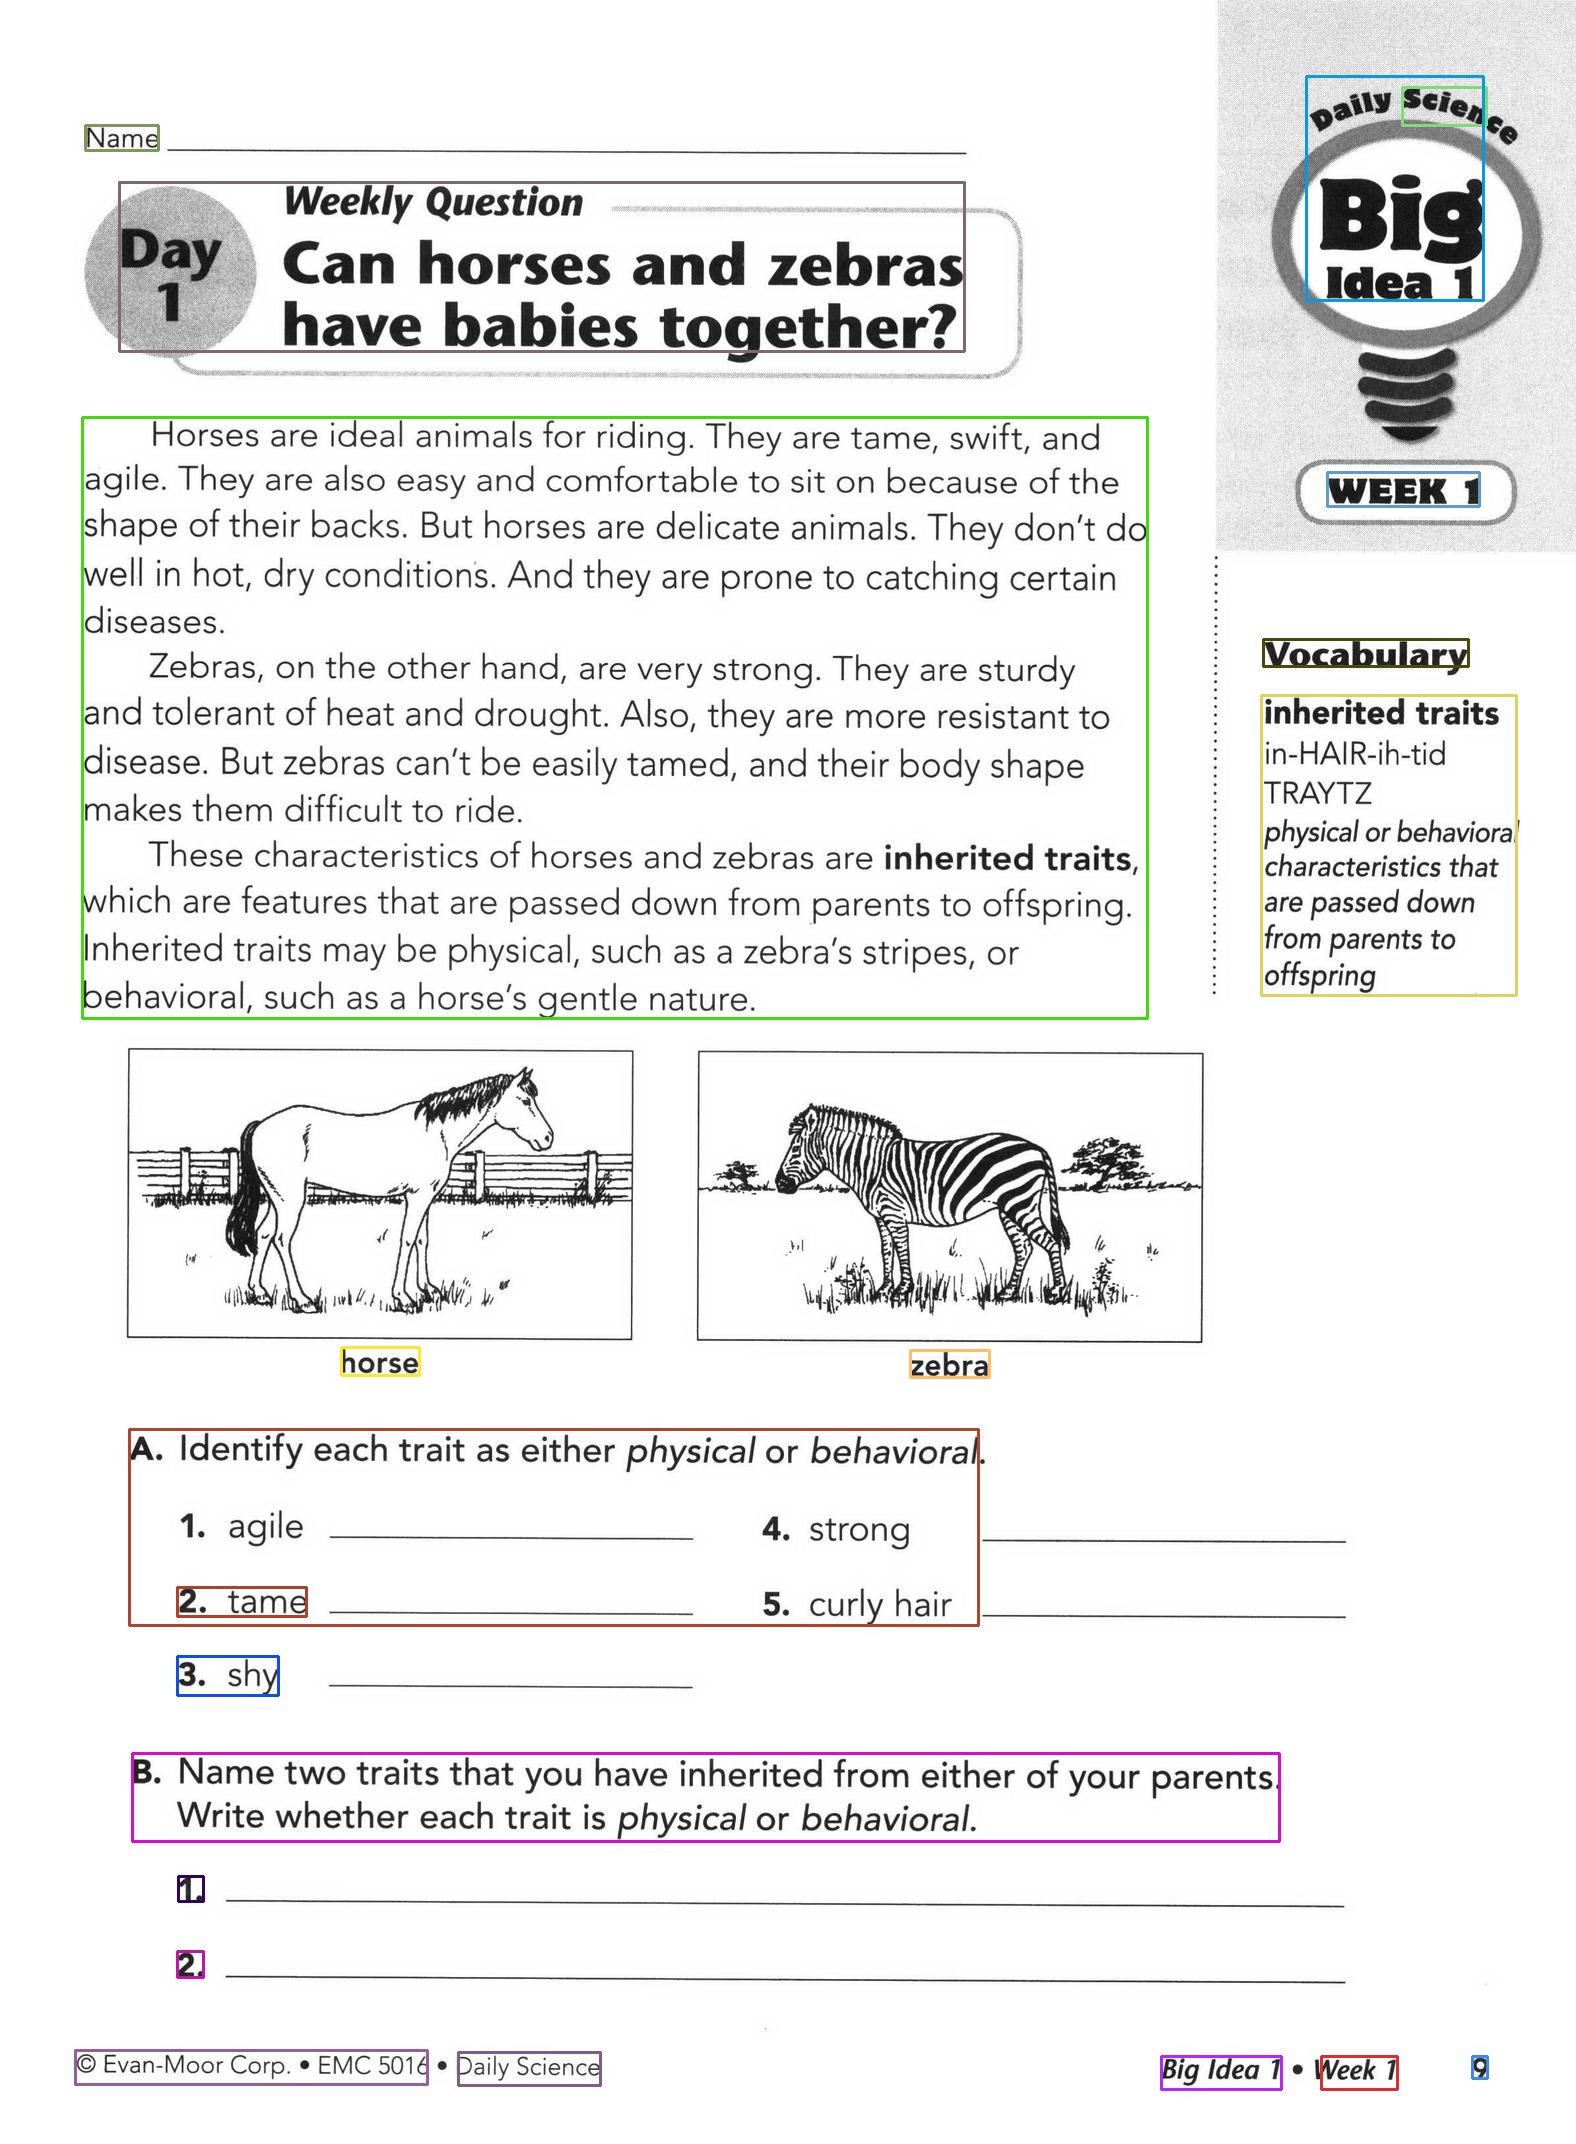

In [654]:
det_obj = det_json_to_obj(ocr_res_prev_unmerged['detections'])
merged_detections = merge_boxes_service_response(det_obj, 1)

pil_image = tpi.convert('RGB') 
open_cv_image = np.array(pil_image) 
open_cv_image = open_cv_image[:, :, ::-1].copy() 

def point_to_tuple(box):
    return tuple(OrderedDict(sorted(box.items())).values())

def get_bbox_tuples(detection):
    return map(point_to_tuple, detection['rectangle'])

for box in merged_detections:
    lr, ul = get_bbox_tuples(box.to_JSON())
    cv2.rectangle(open_cv_image, ul, lr, color=random_color(), thickness=2)
display(Image.fromarray(open_cv_image, 'RGB'))

# Updating annotations with verticle dimension

In [9]:
import glob
import json
import pickle
import pdfextraction.merge as merging_tool
import pdfextraction.ocr_pipeline as ocp

In [10]:
def load_local_annotation(page_name):
    base_path = '/Users/schwenk/wrk/notebooks/stb/ai2-vision-turk-data/textbook-annotation-test/unmerged-annotations/'
    file_path = base_path + page_name.replace('jpeg', 'json')
    with open(file_path, 'r') as f:
        local_annotations = json.load(f)
    return local_annotations

def add_anno_img_dim(img_dir, annotations_folder):
    for img in glob.glob(img_dir):
        img_name = img.rsplit('/')[-1]
        anno_file_name = img_name.replace('jpeg', 'json')
        try:
            existing_annotations = load_local_annotation(img_name)
            with open(img) as f:
                v_dim = ocp.record_image_size(f.read())[1]
            try:
                for box_name, box in existing_annotations['text'].items():
                    box['v_dim'] = v_dim
            except KeyError:
                print img
            file_path = annotations_folder + anno_file_name
            with open(file_path, 'wb') as f:
                json.dump(existing_annotations, f)
        except IOError:
            pass            

In [11]:
img_dir = './ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/*'
new_a_dir = './ai2-vision-turk-data/textbook-annotation-test/annotations_ws/'

process_annotation_results(img_dir, new_a_dir)

./ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/DK_Workbooks_Science_Second_Grade_DK_Publishing_64.jpeg
./ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/DK_Workbooks_Science_Third_Grade_DK_Publishing_64.jpeg
./ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/Science_Essentials_Grades_3-4_School_Specialty_Publishing_163.jpeg


# Merging boxes

In [34]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

import glob
import pickle
import pdfextraction.merge as merging_tool
import pdfextraction.ocr_pipeline as ocp

In [35]:
def load_book_info():
    with open('./breakdowns.pkl', 'rb') as f:
        # book_breakdowns = pickle.load(f, encoding='latin1')
        book_breakdowns = pickle.load(f)

    with open('pdfs/page_ranges.csv') as f:
        ranges = f.readlines()
    range_lookup = {line.split(' ')[0]:[int(num) for num in line.strip().split(' ')[1:]] for line in ranges}
    return book_breakdowns, range_lookup

In [38]:
#     'near_x': 3.0,
#     'near_y': 2.0,
#     'overlap_x': 0.8,
#     'overlap_y': 0.6,
#     'start_x': 1.0,
#     'short_length': 1.0,
#     'char_size_ratio': 0.4,
#     'starting_near_near_y': 3.0,
#     'overlap_fract': 0.2

In [36]:
pwd

u'/Users/schwenk/wrk/notebooks/stb'

In [132]:
book_breakdowns['daily_sci']

['Daily_Science_Grade_1_Evan_Moor.pdf',
 'Daily_Science_Grade_2_Evan_Moor.pdf',
 'Daily_Science_Grade_3_(Daily_Practice_Books)_Evan_Moore.pdf',
 'Daily_Science_Grade_4_Evan_Moor.pdf',
 'Daily_Science_Grade_5_Evan_Moor.pdf',
 'Daily_Science_Grade_6_(Daily_Practice_Books)_Evan_Moor.pdf']

In [261]:
merge_params = {
    'near_x': 3.0,
    'near_y': 1.0,
    'overlap_x': 0.30,
    'overlap_y': 0.6,
    'start_x': 1.0,
    'short_length': 4.0,
    'char_size_ratio': 1.0,
    'starting_near_near_y': 1.5,
    'near_overlap_x': 0.35,
    'overlap_fract': 0.1
}

book_breakdowns, page_ranges = load_book_info()
dest_path = './ai2-vision-turk-data/textbook-annotation-test/merged-annotations/'
for textbook in book_breakdowns['daily_sci'] + book_breakdowns['spectrum_sci'] + book_breakdowns['read_und_sci'] + book_breakdowns['workbooks']:
# for textbook in book_breakdowns['daily_sci'][0:2]:
    merging_tool.merge_single_book(textbook, page_ranges[textbook], dest_path, merge_params)

In [259]:
"""


Best after much fiddling, going into production with these


"""

'\n\n\nBest after much fiddling, going into production with these\n\n\n'

In [260]:
%%capture
%save -a   experiment_merge_notes.py 259
%save -a experiment_merge_notes.py 258

# Rectify ocr

In [289]:
base_path = 'ai2-vision-turk-data/textbook-annotation-test/'
page_name = 'Daily_Science_Grade_2_Evan_Moor_61.json'

page_name = 'Daily_Science_Grade_2_Evan_Moor_140.json'

In [290]:
with open(base_path + 'labeled-annotations/' + page_name) as f:
    labeled_anno = json.load(f)

with open(base_path + 'first-merge/' + page_name) as f:
# with open(base_path + 'raw-ocr-ws/' + page_name) as f:    
    better_ocr = json.load(f)

In [270]:
for a_type in labeled_anno.values():
    for box in a_type.values():
        print box['category']
        print box['contents']
        print

unlabeled
WEEK 5

Question
correct answer.

unlabeled
Idea 4

Question
A. Read each question. Fill in the bubble next to the

Header/Topic
Comprehension Looking at the Sky

unlabeled
Unit Review

unlabeled
Name

unlabeled
Big

unlabeled
My Scie Scieo

Question
moves faster seems to change shape

Question
B. Read each sentence. Circle true or false

Question
1. During an eclipse, we can't see the sun 2. A constellation is a group of stars and moons

Question
true false false true

Question
1. Why don't we see the sun at night? A The sun has moved to the other side of Earth Our part of Earth has turned away from the sun OB C Earth stops rotating at night and takes a rest.

Question
2. Why do some constellations change position in the night sky during the year? A The sun outshines the stars B The moon has phases Earth moves through space

Question
3. The moon is not a planet because it A orbits Earth instead of the sun OB makes its own light is too large to be a planet

Question
4. As the

In [271]:
for a_type in better_ocr.values():
    for box in a_type.values():
        print box['contents']

WEEK 5
correct answer.
Idea 4
A. Read each question. Fill in the bubble next to the
Comprehension Review Looking at the Sky Review
Unit
Name
Big
Scieo lly Sci
4. As the moon changes phases, it A makes its own light (B) moves faster C seems to change shape
B. Read each sentence. Circle true or false.
1. During an eclipse, we can't see the sun false 2. A constellation is a group of stars and moons. true
false
1. Why don't we see the sun at night? A The sun has moved to the other side of Earth.
B Earth stops rotating at night and takes a rest. Our part of Earth has turned away from the sun. OB C Earth stops rotating at night and takes a rest.
2. Why do some constellations change position in the night sky during the year? A The sun outshines the stars. B The moon has phases. Earth moves through space.
3. The moon is not a planet because it A orbits Earth instead of the sun OB makes its own light C is too large to be a planet
Week 5
122 122 Big Idea 4
true
Daily Science EMC 5012 Evan-Moor C

In [302]:
def box_overlaps(this_box, other_box, overlap_tol_fract):
    this_coords = [start_x(this_box), start_y(this_box), end_x(this_box), end_y(this_box)]
    other_coords = [start_x(other_box), start_y(other_box), end_x(other_box), end_y(other_box)]

    def area(box):
        return (end_y(box) - start_y(box)) * (end_x(box) - start_x(box))

    dx = min(this_coords[2], other_coords[2]) - max(this_coords[0], other_coords[0])
    dy = min(this_coords[3], other_coords[3]) - max(this_coords[1], other_coords[1])
    if (dx >= 0) and (dy >= 0):
        intersection_area = dx * dy
        return float(intersection_area) / min(area(this_box), area(other_box)) > overlap_tol_fract
    else:
        return False


def find_constituent_boxes(unmerged_anno, merged_anno_box, overlap_tol_fract):
    constituent_boxes = []
    for box_name, box_vals in unmerged_anno['text'].items():
        if box_overlaps(box_vals['rectangle'], merged_anno_box['rectangle'], overlap_tol_fract):
            box_vals['category'] = merged_anno_box['category']
            constituent_boxes.append(box_vals)
    return constituent_boxes


def transmit_labels(unmerged_annotations, merged_annotations, overlap_tol_fract):
    new_annotations = []
    for box_name, box_val in merged_annotations['text'].items():
        atomic_boxes = find_constituent_boxes(unmerged_annotations, box_val, overlap_tol_fract)
        if atomic_boxes:
            new_annotations.extend(atomic_boxes)
#         else:
#             new_annotations.append(box_val)
    sorted_boxes = sorted(new_annotations, key=lambda x: x['rectangle'][0][1])
    unmerged_text_named = {'T' + str(i + 1): sorted_boxes[i] for i in range(len(sorted_boxes))}
    for name, detection in unmerged_text_named.items():
        detection['box_id'] = name
    return unmerged_text_named


def write_transmitted_annotations(unmerged_text_anno, new_file_path):
    full_anno = {"text": unmerged_text_anno, "figure": {}, "relationship": {}}
    with open(new_file_path, 'w') as f:
        json.dump(full_anno, f)

In [303]:
def start_x(box):
    return box[0][0]


def start_y(box):
    return box[0][1]


def end_x(box):
    return box[1][0]


def end_y(box):
    return box[1][1]


def box_overlaps(this_box, other_box, merge_p):
    this_coords = [start_x(this_box), start_y(this_box), end_x(this_box), end_y(this_box)]
    other_coords = [start_x(other_box), start_y(other_box), end_x(other_box), end_y(other_box)]

    def area(box):
        return (end_y(box) - start_y(box)) * (end_x(box) - start_x(box))

    dx = min(this_coords[2], other_coords[2]) - max(this_coords[0], other_coords[0])
    dy = min(this_coords[3], other_coords[3]) - max(this_coords[1], other_coords[1])
    if (dx >= 0) and (dy >= 0):
        intersection_area = dx * dy
        return float(intersection_area) / min(area(this_box), area(other_box))
    else:
        return False

def find_constituent_boxes(unmerged_anno, merged_anno_box):
    constituent_boxes = []
    for box_name, box_vals in unmerged_anno['text'].items():
        if box_vals['contents'] == 'echo':
            print box_vals['rectangle']
            print merged_anno_box['rectangle']
            
            print box_overlaps(box_vals['rectangle'], merged_anno_box['rectangle'], 0.95)
            print merged_anno_box['contents']
        if box_overlaps(box_vals['rectangle'], merged_anno_box['rectangle'], 0.95):
#         if box_is_contained(box_vals['rectangle'], merged_anno_box['rectangle']):
            box_vals['category'] = merged_anno_box['category']
            constituent_boxes.append(box_vals)
#     print merged_anno_box['contents']
#     print [box['contents'] for box in constituent_boxes]
#     print
    return constituent_boxes


def transmit_labels(unmerged_annotations, merged_annotations, box_cat='Question'):
    new_annotations = []
    for box_name, box_val in merged_annotations['text'].items():
        if box_val['category'] == box_cat or True:
            atomic_boxes = find_constituent_boxes(unmerged_annotations, box_val)
            if atomic_boxes:
                new_annotations.extend(atomic_boxes)
            else:
                new_annotations.append(box_val)
        else:
            new_annotations.append(box_val)
    sorted_boxes = sorted(new_annotations, key=lambda x: x['rectangle'][0][1])
    unmerged_text_named = {'T' + str(i + 1): sorted_boxes[i] for i in range(len(sorted_boxes))}
    for name, detection in unmerged_text_named.items():
        detection['box_id'] = name
    return unmerged_text_named


def write_transmitted_annotations(unmerged_text_anno, new_file_path):
    full_anno = {"text": unmerged_text_anno, "figure": {}, "relationship": {}}
    with open(new_file_path, 'w') as f:
        json.dump(full_anno, f)


In [304]:
transmitted_anno_path = base_path + 'transferred-labels-first-round/' + page_name
newly_labeled = transmit_labels(better_ocr, labeled_anno, 0.8)
# newly_labeled = transmit_labels(labeled_anno, better_ocr, 0.95)
write_transmitted_annotations(newly_labeled, transmitted_anno_path)

[[306, 549], [398, 595]]
[[304, 547], [984, 589]]
0.869565217391
echo reflected sound waves echo reflected sound waves
[[306, 549], [398, 595]]
[[239, 681], [1117, 726]]
False
When sound vibrations travel, they are called
[[306, 549], [398, 595]]
[[123, 445], [1074, 487]]
False
A. Complete the paragraph. Use the words in the box.
[[306, 549], [398, 595]]
[[1319, 473], [1477, 507]]
False
WEEK 2
[[306, 549], [398, 595]]
[[113, 189], [801, 355]]
False
Weekly Question Day Where do echoes come from?
[[306, 549], [398, 595]]
[[1317, 262], [1469, 300]]
False
Idea 5
[[306, 549], [398, 595]]
[[77, 128], [151, 156]]
False
Name
[[306, 549], [398, 595]]
[[1309, 175], [1474, 263]]
False
Big
[[306, 549], [398, 595]]
[[1323, 85], [1477, 125]]
False
ally Scie Scieo
[[306, 549], [398, 595]]
[[175, 1081], [744, 1122]]
False
returns to us, we hear it as an
[[306, 549], [398, 595]]
[[129, 1212], [1247, 1357]]
False
B. Color the picture. Use blue to color the sound waves coming from the children. Use green

In [288]:
for box in newly_labeled.values():
    print box['category']
    print box['contents']
    print

unlabeled
0.

unlabeled
O.

Question
Fill in the bubble next to the correct answer.

Question
1. Why do bats use echolocation?

Discussion
echolocation.

Definition
echolocation a way that some animals use sound waves to find things

Discussion
Shrews are another example. They use echolocation to find out if dangerous animals are in their tunnels.

unlabeled
.0

Question
to stay warm

Question
A to find food

unlabeled
Daily Science Evan-Moor Corp. EMC 5012. Daily Science. EMC 5012. OEvan-Moor Corp.

unlabeled
WEEK 2

unlabeled
Vocabulary

unlabeled
Idea 5

Discussion
Many animals use echoes to survive. For example, bats use echoes to find food. They send out sound waves that bounce off insects. An echo tells a bat how far away and how big the insect is! This is called

Header/Topic
Weekly Question Day where do echoes Day 4 come from?

Header/Topic
Weekly Question Day where do echoes Day 4 come from?

unlabeled
Name

unlabeled
Big

unlabeled
SCieo ally Scie

unlabeled
Daily Science Eva

# End